In [109]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/adouillard/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imshow']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [110]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import utils as tutils
from torch import optim
from torchvision import transforms
from torchvision import datasets
from torchvision import utils as vutils
from torchvision import models

import datasetsaver as ds

# 1. Set-up

In [111]:
batch_size = 8
n_epoch = 3

In [124]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

mnist_train = datasets.MNIST(ds.get_path('mnist'), train=True, download=True, transform=transform)
trainloader = tutils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = datasets.MNIST(ds.get_path('mnist'), train=False, download=True, transform=transform)
testloader = tutils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

classes_mnist = tuple(i for i in range(10))

In [131]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def display_batch(images, labels, classes):
    imshow(vutils.make_grid(images))
    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

def test_on_batch(loader, net, classes):
    images, labels = iter(loader).next()
    display_batch(images, labels, classes)
    
    preds = net(Variable(images))
    _, preds = torch.max(preds, 1)
    preds = preds.data.numpy()
    print('Predicted:\n', ' '.join('%5s' % preds[j] for j in range(batch_size)))
    print('Accuracy: ', 100 * np.mean(preds == labels))

    6     3     8     1     5     2     9     8


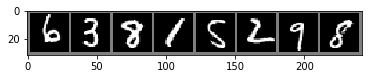

In [128]:
display_batch(*next(iter(trainloader)), classes_mnist)

In [115]:
def test_acc(loader, net):
    correct, total = 0, 0
    
    for data in loader:
        x, y = data
        preds = net(Variable(x))
        _, preds = torch.max(preds, 1)
        preds = preds.data.numpy()
        
        total += y.size(0)
        correct += (preds == y).sum()
        
    print('Accuracy: ', 100 * correct / total)

# 2. CNN from scratch

In [116]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Remember for conv:
        # W2 = (W1 - F + 2P)/S + 1
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def act(self, x):
        return F.relu6(x)
        
    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

In [117]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [118]:
for epoch in range(n_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 1.259
[1,  4000] loss: 0.204
[1,  6000] loss: 0.141
[2,  2000] loss: 0.091
[2,  4000] loss: 0.079
[2,  6000] loss: 0.078
[3,  2000] loss: 0.058
[3,  4000] loss: 0.060
[3,  6000] loss: 0.060


    4     5     5     5     5     4     8     2
Predicted:
     4     5     5     5     5     4     8     2
Accuracy:  100.0


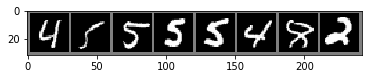

In [132]:
test_on_batch(testloader, net, classes_mnist)

In [120]:
test_acc(testloader, net)

Accuracy:  97.67


# 3. Fine-tuning

In [144]:
batch_size = 32

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

cifar_train = datasets.CIFAR10(ds.get_path('cifar10'), train=True, download=True, transform=transform)
trainloader = tutils.data.DataLoader(cifar_train, batch_size=batch_size, shuffle=True)

cifar_test = datasets.CIFAR10(ds.get_path('cifar10'), train=False, download=True, transform=transform)
testloader = tutils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

vgg16 = models.vgg16_bn(pretrained=True)

Files already downloaded and verified
Files already downloaded and verified


In [145]:
print('Top part of vgg16:')
list(vgg16.classifier.children())

Top part of vgg16:


[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace),
 Dropout(p=0.5),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace),
 Dropout(p=0.5),
 Linear(in_features=4096, out_features=1000, bias=True)]

In [ ]:
for param in vgg16.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.BatchNorm1d(4096),
    nn.ReLU(True),
    nn.Linear(4096, 4096),
    nn.BatchNorm1d(4096),
    nn.ReLU(True),
    nn.Linear(4096, 10)
)

vgg16.classifier = classifier

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
n_epoch = 25

for epoch in range(n_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0